In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
from torchviz import make_dot

In [2]:
# Load the Dataset

import pandas as pd
from sklearn.model_selection import train_test_split
L = 6 
df = pd.read_csv("music.csv")
#labels = np.array(df.columns.values.tolist())[0:L]
XY = df.values
N,n_columns = XY.shape
D = n_columns - L
X = XY[:,L:n_columns]
Y = XY[:,0:L]
Y = XY[:,0:L].astype(int).tolist()
X = XY[:,L:].astype(float).tolist()
N_test = 30
N_train = N-N_test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=N_test, random_state=42)


In [11]:
print(len(Y_train[0]))

6


In [12]:
# Design the model

class multilabel_classifier(nn.Module):

    def __init__(self, D, L, H=10):
        super(multilabel_classifier, self).__init__()

        L_1 = int(L/2)
        L_2 = L - L_1
        self.linear1_1 = nn.Linear(D, L_1)
        
        self.linear2_1 = nn.Linear(D, H)
        self.linear2_2 = nn.Linear(H, L_2)
        
        

    def forward(self, x):

        y_1 = self.linear1_1(x)
        y_2 = self.linear2_1(x)
        y_2 = self.linear2_2(y_2)
        y = torch.cat((y_1, y_2), dim=1) 
        y = torch.sigmoid(y)
        # y = torch.round(y)
        
        return y
            

In [13]:
h = multilabel_classifier(D,L)

torch.manual_seed(0)
np.random.seed(0)

# Set up the loss
optimizer = optim.Adam(h.parameters(),0.001)

my_loss = torch.nn.BCELoss()

outputs = []

# Fit the Model
n_epochs = 100
for t in range(n_epochs):
    losses = []
    for i in range(N_train):
        h.train()
        x_variable = torch.FloatTensor(X_train[i]).view(1, -1)
        y_variable = torch.FloatTensor(Y_train[i]).view(1, -1)
        
        output = h(x_variable)
        p_y = torch.Tensor.numpy(output.detach())
        
        loss = my_loss(output, y_variable)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.mean())
    print('[%d/%d] Loss: %.3f' % (t+1, n_epochs, np.mean(losses)))




[1/100] Loss: 0.806
[2/100] Loss: 0.610
[3/100] Loss: 0.558
[4/100] Loss: 0.531
[5/100] Loss: 0.516
[6/100] Loss: 0.506
[7/100] Loss: 0.498
[8/100] Loss: 0.492
[9/100] Loss: 0.488
[10/100] Loss: 0.483
[11/100] Loss: 0.480
[12/100] Loss: 0.476
[13/100] Loss: 0.473
[14/100] Loss: 0.471
[15/100] Loss: 0.468
[16/100] Loss: 0.466
[17/100] Loss: 0.464
[18/100] Loss: 0.462
[19/100] Loss: 0.461
[20/100] Loss: 0.459
[21/100] Loss: 0.457
[22/100] Loss: 0.456
[23/100] Loss: 0.454
[24/100] Loss: 0.453
[25/100] Loss: 0.452
[26/100] Loss: 0.451
[27/100] Loss: 0.449
[28/100] Loss: 0.448
[29/100] Loss: 0.447
[30/100] Loss: 0.446
[31/100] Loss: 0.445
[32/100] Loss: 0.444
[33/100] Loss: 0.443
[34/100] Loss: 0.443
[35/100] Loss: 0.442
[36/100] Loss: 0.441
[37/100] Loss: 0.440
[38/100] Loss: 0.439
[39/100] Loss: 0.438
[40/100] Loss: 0.438
[41/100] Loss: 0.437
[42/100] Loss: 0.436
[43/100] Loss: 0.436
[44/100] Loss: 0.435
[45/100] Loss: 0.434
[46/100] Loss: 0.434
[47/100] Loss: 0.433
[48/100] Loss: 0.433
[

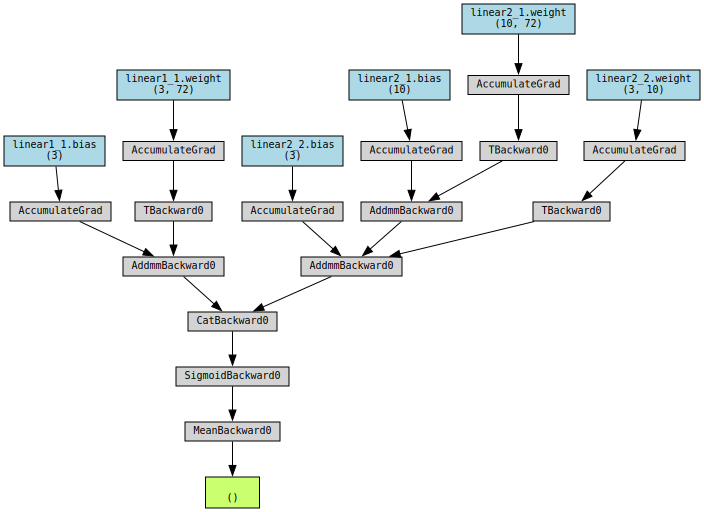

In [74]:
# Visualize

# brew install graphviz -> sinon ça ne marche pas

x = torch.randn(1,D)
y = h(x)
make_dot(y.mean(), params=dict(h.named_parameters()))

In [14]:
# Test the model on test data and compute my_loss on test data
preds = [] 
losses_t = []
with torch.no_grad():
   for i in range(N_test):
        
        x_t_variable = torch.FloatTensor(X_test[i]).view(1, -1)
        y_t_variable = torch.FloatTensor(Y_test[i]).view(1, -1)
        
        y_hat = h(x_t_variable)
        preds.append(y_hat)
        loss = my_loss(y_hat, y_t_variable)
        losses_t.append(loss.data.mean())
   print('my_loss: %.3f' % (np.mean(losses_t)))

my_loss: 0.457


In [78]:
def hamming_loss(y,pred):
    c = 0
    d = 0
    temp = torch.eq(y, pred)
    for el in temp[0]:
        d+=1
        if not el.item() :
            c+=1
    return c/d
    
def loss_0_1(y,pred):
    if hamming_loss(y,pred)>0:
        return 1
    return 0

In [79]:
# Test the model on test data and compute my_loss on test data
preds = [] 
hamlosses_t = []
losses_0_1_t = []
for i in range(N_test):   
     x_t_variable = torch.FloatTensor(X_test[i]).view(1, -1)
     y_t_variable = torch.FloatTensor(Y_test[i]).view(1, -1)
     
     y_hat = h(x_t_variable)
     preds.append(y_hat)
     y_hat = torch.round(y_hat)

     hamloss = hamming_loss(y_hat, y_t_variable)
     loss01 = loss_0_1(y_hat, y_t_variable)
     
     hamlosses_t.append(hamloss)
     losses_0_1_t.append(loss01)
     
print('Hamming loss: %.3f' % (np.mean(hamlosses_t)))
print('0/1 loss: %.3f' % (np.mean(losses_0_1_t)))

Hamming loss: 0.211
0/1 loss: 0.700
